# Comparing the MCE and Maier chemical libraries

In [106]:
import os
# Data Manipulation
import numpy as np
import pandas as pd

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# Low dimensional embeddings
import umap


## Prepare directories

In [107]:
RAW_DATA_DIR = "../raw_data"

MAIER_DIR = "../data/01.prepare_training_data/"
MCE_DIR = "../data/04.new_predictions/"

OUTPUT_DIR = "../data/08.compare_mce_maier"
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Read Data

In [108]:
# MolE representations

maier_mole = pd.read_csv(os.path.join(MAIER_DIR, "maier_mole_representation.tsv.gz"), sep='\t', index_col=0)
mce_mole = pd.read_csv(os.path.join(MCE_DIR, "MolE_representation_medchemexpress.tsv.gz"), sep='\t', index_col=0)

# Fingerprint representations
maier_fps = pd.read_csv(os.path.join(MAIER_DIR, "maier_ecfp4_representation.tsv.gz"), sep='\t', index_col=0)
mce_fps = pd.read_csv(os.path.join(MCE_DIR, "ecfp4_representation_medchemexpress.tsv.gz"), sep='\t', index_col=0)

In [109]:
## Metadata
mce_metadata = pd.read_excel(os.path.join(MCE_DIR, "mole_mce_predictions.xlsx"), sheet_name="mole_prediction_overview")
maier_metadata = pd.read_excel(os.path.join(RAW_DATA_DIR, "maier_microbiome", "chem_library_info_SF1.xlsx"))

# Show the molecules used for training
maier_split = pd.read_csv(os.path.join(MAIER_DIR, "maier_scaffold_split.tsv.gz"), sep='\t')
maier_train = maier_split.loc[maier_split["split"]=="train", "prestwick_ID"].unique()

In [110]:
# Pre-filter shared compounds from MCE library
mce_mole = mce_mole.loc[mce_metadata["Catalog Number"].unique()]
maier_mole = maier_mole.loc[maier_train]


# Pre-filter shared compounds from MCE library
mce_fps = mce_fps.loc[mce_metadata["Catalog Number"].unique()]
maier_fps = maier_fps.loc[maier_train]

## UMAP embeddings

In [111]:
# MolE representation
combined_mole = pd.concat([mce_mole, maier_mole])

reducer = umap.UMAP(random_state=42, n_components=2, n_neighbors=25, min_dist=0.3, metric="cosine")

embedding = reducer.fit_transform(combined_mole.values)

mole_umap = pd.DataFrame(data = embedding,
                          columns = ['umap1', 'umap2'], 
                          index = combined_mole.index)
                          
# Add chemical library origin
mole_umap = mole_umap.reset_index(names="chem_id")

mole_umap["Chemical Library"] = mole_umap["chem_id"].apply(lambda x: "MCE" if x in mce_metadata["Catalog Number"].unique() else "Maier et.al.")
mole_umap.head()

/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


,chem_id,umap1,umap2,Chemical Library
0,HY-16980A,4.067525,5.113844,MCE
1,HY-B2136,12.631118,6.912557,MCE
2,HY-B0117,4.246848,5.116776,MCE
3,HY-A0059,7.663646,4.441543,MCE
4,HY-B0117C,4.266520,5.088496,MCE


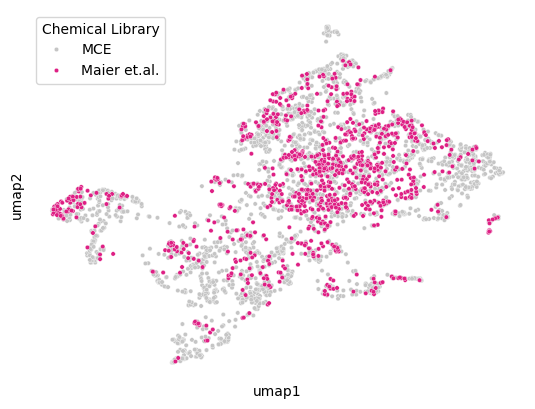

In [119]:
sns.scatterplot(mole_umap, x="umap1", y="umap2", s=10, hue="Chemical Library",
                palette={"MCE": "#C5C5C5", "Maier et.al.": "#DE1F84"})
sns.despine(bottom=True, left=True)
plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
#plt.legend(frameon=False)

In [127]:
## Ecfp4 representation
combined_fps = pd.concat([mce_fps, maier_fps])

reducer = umap.UMAP(random_state=42, n_components=2, n_neighbors=25, min_dist=0.3, metric="jaccard")

embedding = reducer.fit_transform(combined_fps.values)

fps_umap = pd.DataFrame(data = embedding,
                          columns = ['umap1', 'umap2'], 
                          index = combined_fps.index)
                          
# Add mol weight information
fps_umap = fps_umap.reset_index(names="chem_id")
fps_umap["Chemical Library"] = fps_umap["chem_id"].apply(lambda x: "MCE" if x in mce_metadata["Catalog Number"].unique() else "Maier et.al.")
fps_umap.head()

/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


,chem_id,umap1,umap2,Chemical Library
0,HY-16980A,7.874295,6.752480,MCE
1,HY-B2136,11.704567,12.252131,MCE
2,HY-B0117,7.904639,6.698757,MCE
3,HY-A0059,11.796303,14.701802,MCE
4,HY-B0117C,7.837804,6.662528,MCE


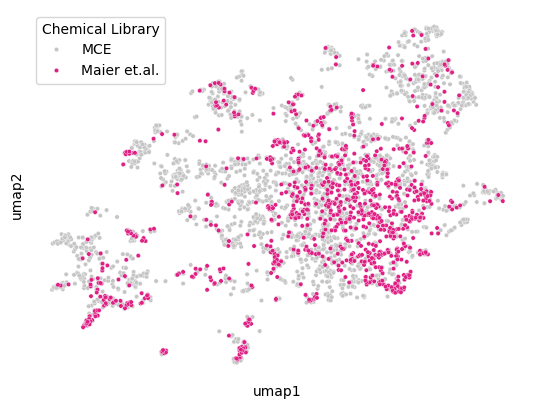

In [128]:
sns.scatterplot(fps_umap, x="umap1", y="umap2", s=10, hue="Chemical Library",
                palette={"MCE": "#C5C5C5", "Maier et.al.": "#DE1F84"})
sns.despine(bottom=True, left=True)
plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

## Highlight examples from literature

In [99]:
mce_litexamples = pd.read_excel(os.path.join(MCE_DIR, "mole_mce_predictions_litsearch.xlsx"), sheet_name="mole_over10")
mce_litexamples["Reported Activity"] = mce_litexamples["Reported Activity"].fillna("no_activity_reported")
mce_litexamples = mce_litexamples.loc[(mce_litexamples["antibiotic"]=="not_abx") &
                                      (mce_litexamples["Reported Activity"] != "no_activity_reported")]
mce_litexamples_dict = mce_litexamples.set_index("Catalog Number")[["ProductName"]].to_dict()["ProductName"]

In [100]:
highlight_chems = ["HY-B0183", # Ellagic acid
                   "HY-B0021", # Doxifluridine
                   "HY-N0829", # Shionone
                   "HY-B0723", # Ospemifene
                   "HY-B2136" # Tannic acid
                   ]

/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/matplotlib/text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecat

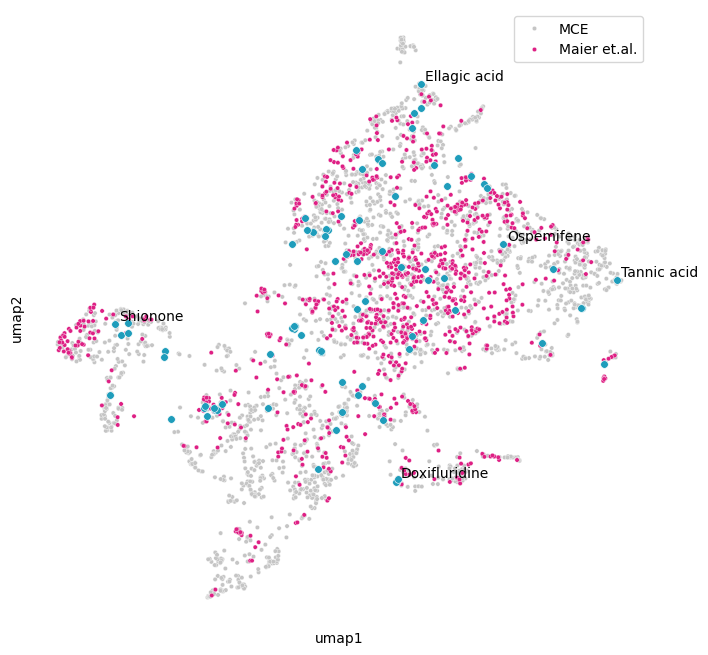

In [131]:
plt.figure(figsize=(8,8))

sns.scatterplot(mole_umap, x="umap1", y="umap2", s=10, hue="Chemical Library",
                 palette={"MCE": "#C5C5C5", "Maier et.al.": "#DE1F84"})

sns.scatterplot(mole_umap.loc[mole_umap["chem_id"].isin(list(mce_litexamples_dict.keys()))],
                x="umap1", y="umap2", s=30, color="#1F9DBB")

for cid in highlight_chems:
    chem_umap = mole_umap.loc[mole_umap["chem_id"]==cid]

    plt.text(x=chem_umap.umap1 + 0.1,
             y=chem_umap.umap2 + 0.1,
             s=mce_litexamples_dict[cid],
             fontdict={"size":10})
    
sns.despine(bottom=True, left=True)
plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/matplotlib/text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecat

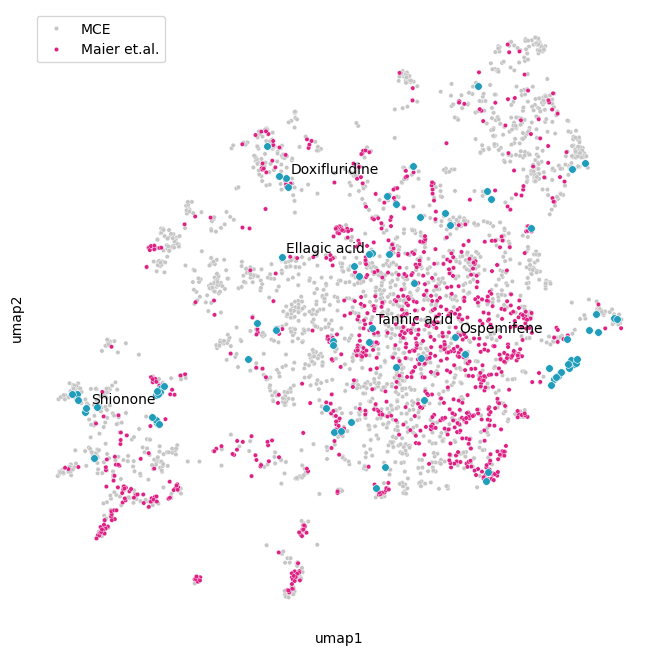

In [132]:
plt.figure(figsize=(8,8))

sns.scatterplot(fps_umap, x="umap1", y="umap2", s=10, hue="Chemical Library",
                 palette={"MCE": "#C5C5C5", "Maier et.al.": "#DE1F84"})

sns.scatterplot(fps_umap.loc[fps_umap["chem_id"].isin(list(mce_litexamples_dict.keys()))],
                x="umap1", y="umap2", s=30, color="#1F9DBB")

for cid in highlight_chems:
    chem_umap = fps_umap.loc[fps_umap["chem_id"]==cid]

    plt.text(x=chem_umap.umap1 + 0.1,
             y=chem_umap.umap2 + 0.1,
             s=mce_litexamples_dict[cid],
             fontdict={"size":10})
sns.despine(bottom=True, left=True)
plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

## Highlight chosen molecules

In [133]:
chosen_chems = {"HY-100474": "Visomitin",
                        "HY-B0674": "Ebastine",
                        "HY-14896": "Opicapone",
                        "HY-14740": "Elvitegravir",
                        "HY-P0009A": "Cetrorelix"}

/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/matplotlib/text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecat

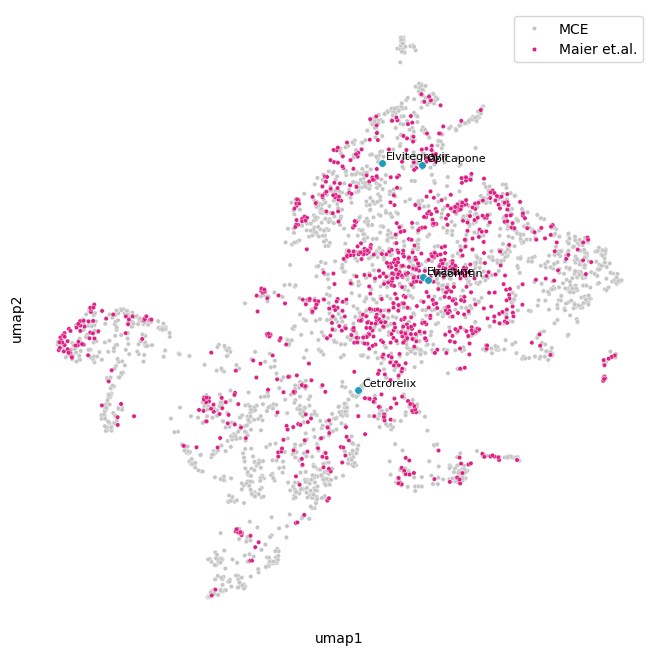

In [135]:
plt.figure(figsize=(8,8))

sns.scatterplot(mole_umap, x="umap1", y="umap2", s=10, hue="Chemical Library",
                 palette={"MCE": "#C5C5C5", "Maier et.al.": "#DE1F84"})

sns.scatterplot(mole_umap.loc[mole_umap["chem_id"].isin(list(chosen_chems.keys()))],
                x="umap1", y="umap2", s=30, color="#1F9DBB")

for cid in chosen_chems.keys():
    chem_umap = mole_umap.loc[mole_umap["chem_id"]==cid]

    plt.text(x=chem_umap.umap1 + 0.1,
             y=chem_umap.umap2 + 0.1,
             s=chosen_chems[cid],
             fontdict={"size":8})
    
sns.despine(bottom=True, left=True)
plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/matplotlib/text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/roberto_olayo/miniconda3/envs/mole/lib/python3.8/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecat

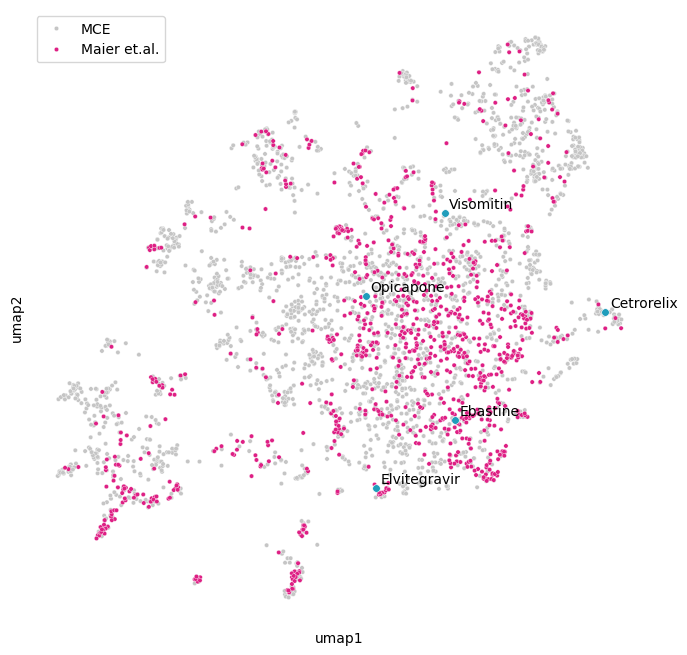

In [136]:
plt.figure(figsize=(8,8))

sns.scatterplot(fps_umap, x="umap1", y="umap2", s=10, hue="Chemical Library",
                 palette={"MCE": "#C5C5C5", "Maier et.al.": "#DE1F84"})

sns.scatterplot(fps_umap.loc[fps_umap["chem_id"].isin(list(chosen_chems.keys()))],
                x="umap1", y="umap2", s=30, color="#1F9DBB")

for cid in chosen_chems.keys():
    chem_umap = fps_umap.loc[fps_umap["chem_id"]==cid]

    plt.text(x=chem_umap.umap1 + 0.1,
             y=chem_umap.umap2 + 0.1,
             s=chosen_chems[cid],
             fontdict={"size":10})
    
    
sns.despine(bottom=True, left=True)
plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
